### This notebook validates the afib results, using both the baseline and the cohort afib models, on microsim. Microsim results are compared against Global Burden of Disease data.

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import importlib.util

In [2]:
from microsim.population import NHANESDirectSamplePopulation
from microsim.sim_settings import simSettings

In [3]:
gbdData=pd.read_csv("/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA/IHME-GBD_2019_DATA-afib/IHME-GBD_2019_DATA-8086e0fc-1.csv")
#gbdData.head(3)
#the reference afib data will be based on the 2019 US GBD data
afibRef = gbdData.loc[ 
    (gbdData["metric_name"]=="Percent") & (gbdData["age_id"].isin([16,17,18,19,20,30,31,32,235]))
    ,["val"]]["val"].tolist()
#afibRef

In [4]:
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

seedSequence = np.random.SeedSequence()
rngStream = np.random.default_rng(seed=seedSequence)

microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [5]:
popSize = 50000
pop = NHANESDirectSamplePopulation(popSize, 2017, rng=rngStream)

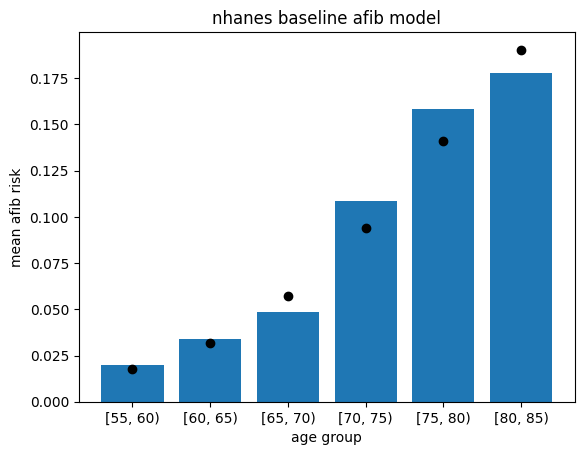

In [6]:
#do the bin counting for the baseline model
ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age
    afibList += p._afib 
    pDone = len(ageList)
    if pDone%100000==0:
        print(pDone)
        
baseAfib = pd.DataFrame(list(zip(ageList,afibList)), columns=["age","afib"])
baseAfib["age"]=baseAfib["age"].astype('int')
baseAfib["ageInterval"] = pd.cut(baseAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)

baseAfibMeansByAgeGroup = baseAfib.groupby("ageInterval").agg({'afib' : 'mean'})
baseAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  baseAfibMeansByAgeGroup.index.array]

labels = baseAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in baseAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes baseline afib model")
plt.show()

In [7]:
alive, dead = pop.advance_vectorized(150,rng=rngStream)

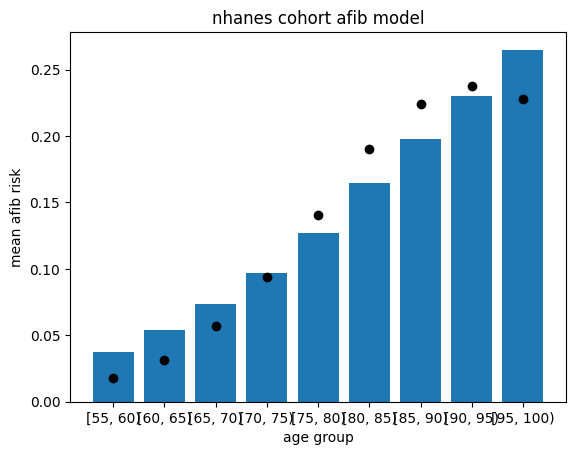

In [8]:
ageList = list()
afibList = list()
for p in pop._people.iloc[:]:
    ageList +=  p._age[1:]
    afibList += p._afib[1:-1] 
        
cohortAfib = pd.DataFrame(list(zip(ageList, afibList)), columns =['age', 'afib'])
cohortAfib["afib"]=cohortAfib["afib"].astype('int')
cohortAfib["age"]=cohortAfib["age"].astype('int')

cohortAfib["ageInterval"] = pd.cut(cohortAfib["age"], bins=[10,55,60,65,70,75,80,85,90,95,100],right=False)
cohortAfibMeansByAgeGroup = cohortAfib.groupby("ageInterval").agg({'afib' : 'mean'})
cohortAfibMeansByAgeGroup["labels"] = [f"[{x.left}, {x.right})" for x in  cohortAfibMeansByAgeGroup.index.array]

labels = cohortAfibMeansByAgeGroup["labels"].values.tolist()[1:]
values = [x[0] for x in cohortAfibMeansByAgeGroup.values[1:]]
reference = [afibRef[i] for i in range(len(labels)) if ~np.isnan(values[i])]

fig, ax = plt.subplots()
ax.bar(labels, values)
for i in range(len(reference)):
    ax.scatter(labels[i],reference[i],color="black")
plt.xlabel("age group")
plt.ylabel("mean afib risk")
plt.title("nhanes cohort afib model")
plt.show()